In [1]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import pyspark
# Macros.
MAX_ITER = 20
DATA_PATH = "gs://bigdata-chu/hw1/data.txt"
C1_PATH = "gs://bigdata-chu/hw1/c1.txt"
C2_PATH = "gs://bigdata-chu/hw1/c2.txt"
NORM = 2
K = 10

### 1. L1 distance as similarity measurement

including the definition of the function and the plots between iteration number and loss function.

In [2]:
# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm))
                    for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    return closest_c ##index


# K-means clustering
def kmeans(data, centroids, norm):
    """
    Conduct k-means clustering given data and centroid.
    This is the basic version of k-means, you might need more
    code to record cluster assignment to plot TSNE, and more
    data structure to record cost.
    Args:
        data (RDD): RDD of points
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        RDD: assignment information of points, a RDD of (centroid, (point, 1))
        list: a list of centroids
        and define yourself...
    """
    
    lossfun = []
    # iterative k-means
    for n in range(MAX_ITER):
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))
        point  = data.map(lambda p: (closest(p,centroids,norm),(p,1))) 
        
        lossfun += [point.map(lambda (c, (p, n)): linalg.norm(p - centroids[c], norm) ** norm).sum()]
        #print(point)
        # Re-compute cluster center
        pointStats = point.reduceByKey(
            lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
        #print(pointStats)##aggregate and sum up the points
        centroids = pointStats.map(
            lambda st: (st[1][0] / st[1][1])).collect() ##average the points
        #loss = min([(i, (linalg.norm(data.map(lambda p: p - c))**norm , norm))
        #        for i, c in enumerate(centroids)],
        #        key=operator.itemgetter(1))[1]
        # For each cluster center (key), aggregate its values
        # by summing up points and count
        #lossfun.append((n, loss))
        # Average the points for each centroid: divide sum of points by count
    result = centroids
        
        # Use collect() to turn RDD into list
    return{'RDD':point, 'centroids': result, 'loss': lossfun, 'centroid': point.keys().collect()}



In [3]:
    # Load the data, cache this since we're accessing this each iteration
data = sc.textFile(DATA_PATH).map(
    lambda line: np.array([float(x) for x in line.split(' ')])
    ).cache() #convert the file to float
    # Load the initial centroids c1, split into a list of np arrays
centroids1 = sc.textFile(C1_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).collect()
    # Load the initial centroids c2, split into a list of np arrays
centroids2 = sc.textFile(C2_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
        ).collect()

In [4]:
c1_result1 = kmeans(data, centroids1, 1)
c2_result1 = kmeans(data,centroids2, 1)

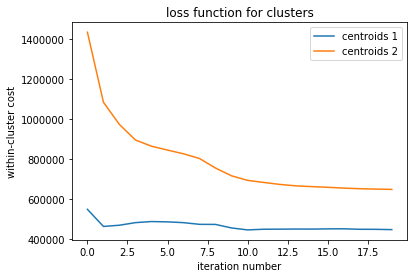

In [5]:
loss_list11 = c1_result1['loss']
iteration_num = range(20)
plt.plot(iteration_num, loss_list11)

loss_list22 = c2_result1['loss']
plt.plot(iteration_num, loss_list22)

plt.xlabel('iteration number')
plt.ylabel('within-cluster cost')
plt.title('loss function for clusters')
plt.legend(['centroids 1', 'centroids 2'], loc='upper right')

plt.show()

### 2. L1 distance as similarity measurement

including the plots required between iteration number and within_cluster cost

In [6]:
#if __name__ == "__main__":
    #sc.stop()
#main()
c1_result = kmeans(data, centroids1, NORM)
c2_result = kmeans(data,centroids2, NORM)

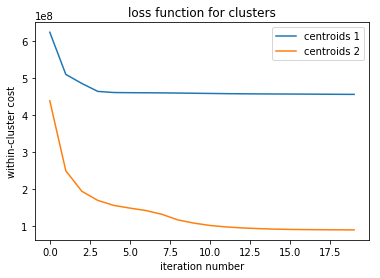

In [7]:
loss_list = c1_result['loss']
#K_array=np.arange(1,10,1)
plt.plot(iteration_num, loss_list)

loss_list2 = c2_result['loss']
iteration_num = range(20)
#K_array=np.arange(1,10,1)
plt.plot(iteration_num, loss_list2)
plt.xlabel('iteration number')
plt.ylabel('within-cluster cost')
plt.title('loss function for clusters')
plt.legend(['centroids 1', 'centroids 2'], loc='upper right')

plt.show()

### 3. Using TSNE to do dimension reduction
including creating a dataset with only two dimensions and plots of the new dataset in L2 distance

In [8]:
from sklearn.manifold import TSNE
import numpy as np
tsne_df = np.array(data.collect())
tsne_df.shape

(4601, 58)

In [9]:
td_df = TSNE(n_components=2, random_state=100).fit_transform(tsne_df)

In [10]:
td_df.shape

(4601, 2)

/opt/conda/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:3261: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data. Using as data.
Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


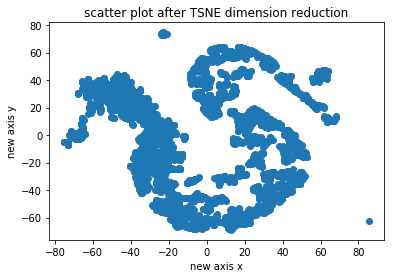

In [11]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Create a dataset:
df=pd.DataFrame({'x': td_df[:,0], 'y':td_df[:,1] })
 
# plot
plt.plot( 'x', 'y', data=df, linestyle='none', marker='o')
plt.xlabel('new axis x')
plt.ylabel('new axis y')
plt.title('scatter plot after TSNE dimension reduction')
plt.show()


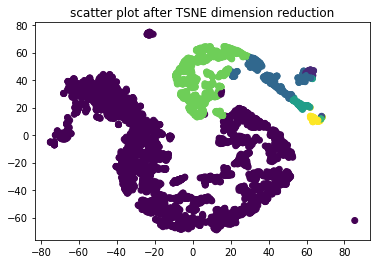

In [12]:
# Create a dataset:
df=pd.DataFrame({'x': td_df[:,0], 'y':td_df[:,1] })
 
# plot
#plt.plot( 'x', 'y', data=df, linestyle='none', marker='o', c = c2_result['centroid'])
plt.scatter(df['x'], df['y'], c=c2_result['centroid'])
#plt.xlabel('new axis x')
#plt.ylabel('new axis y')
plt.title('scatter plot after TSNE dimension reduction')
plt.show()

### 3. Comparing
- For L2 and L1 distance, are random initialization of K-means using ​c1.txt​ better than initialization using ​c2.txt​ in terms of cost?
No, C2.txt tend to have lower within-cluster cost than C1. So C2 is better. It may be resulted from the limited iteration number. Since it takes longer for random points to have more accurate centroids in 20 iterations than points who is furthest from each other and more likely to be within different clusters.

### 4. Time Complexity
o(p*k*m*d) = o(53371600)